# CRISP-DM 1 – İş (Business) Anlayışı:

Bu projenin temel amacı, Delhi şehrine ait günlük iklim verilerini kullanarak ortalama sıcaklık değerini tahmin etmektir. Bu analiz, hava tahmini, enerji tüketim planlaması ve tarımsal faaliyetlerin planlanması gibi alanlarda destekleyici kararlar alınmasına katkı sağlar.

Veri setinde nem, rüzgar hızı ve atmosfer basıncı gibi bağımsız değişkenler yer almaktadır. Bu değişkenler ile ortalama sıcaklık (meantemp) arasında istatistiksel bir ilişki kurulması hedeflenmektedir.
Model, bu değişkenlerden yola çıkarak gelecekteki sıcaklık değerlerini tahmin edecektir.

Bu çalışma, iklim değişkenlerinin sıcaklık üzerindeki etkisini anlamaya ve geleceğe yönelik kısa vadeli sıcaklık tahminleri yapmaya imkân tanır. Özellikle enerji yönetimi ve şehir 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 2. CRISP-DM Aşaması: Veri Anlama (Data Understanding):

In [2]:
test_data = pd.read_csv("DailyDelhiClimateTest.csv")

In [3]:
train_data = pd.read_csv("DailyDelhiClimateTrain.csv")


In [4]:
NUM_COLS = ["meantemp", "humidity", "wind_speed", "meanpressure"]

def to_numeric_clean(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = (
                df[c].astype(str)
                      .str.replace(",", "", regex=False)  # 1,015.667 -> 1015.667
                      .str.replace(" ", "", regex=False)
            )
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

In [5]:
train = train_data.copy()
test  = test_data.copy()
for d in (train, test):
    if "date" in d.columns:
        d["date"] = pd.to_datetime(d["date"], errors="coerce")

In [6]:
train = to_numeric_clean(train, NUM_COLS)
test  = to_numeric_clean(test,  NUM_COLS)

In [7]:
print("=== TRAIN Şekil / Kolonlar ===")
print(train.shape, list(train.columns))
print("\n=== TRAIN Dtypes ===")
print(train.dtypes)

print("\n=== TEST Şekil / Kolonlar ===")
print(test.shape, list(test.columns))
print("\n=== TEST Dtypes ===")
print(test.dtypes)

print("\n=== İlk 5 satır (train) ===")
display(train.head())

=== TRAIN Şekil / Kolonlar ===
(1462, 5) ['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']

=== TRAIN Dtypes ===
date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object

=== TEST Şekil / Kolonlar ===
(114, 5) ['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']

=== TEST Dtypes ===
date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object

=== İlk 5 satır (train) ===


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [8]:
print("\n=== Eksik Değer Sayıları (train) ===")
print(train.isna().sum().sort_values(ascending=False))
print("\n=== Eksik Değer Oranları % (train) ===")
print((train.isna().mean()*100).round(2))

print("\n=== Eksik Değer Sayıları (test) ===")
print(test.isna().sum().sort_values(ascending=False))


=== Eksik Değer Sayıları (train) ===
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

=== Eksik Değer Oranları % (train) ===
date            0.0
meantemp        0.0
humidity        0.0
wind_speed      0.0
meanpressure    0.0
dtype: float64

=== Eksik Değer Sayıları (test) ===
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [9]:
print("\n=== Tanımlayıcı İstatistikler (train sayısal) ===")
display(train[NUM_COLS].describe().T)


=== Tanımlayıcı İstatistikler (train sayısal) ===


,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333


In [10]:
if "date" in train.columns:
    print("\nTarih aralığı (train):", train["date"].min(), "→", train["date"].max())


Tarih aralığı (train): 2013-01-01 00:00:00 → 2017-01-01 00:00:00



=== Korelasyon Matrisi (train) ===


,meantemp,humidity,wind_speed,meanpressure
meantemp,1.000000,-0.571951,0.306468,-0.038818
humidity,-0.571951,1.000000,-0.373972,0.001734
wind_speed,0.306468,-0.373972,1.000000,-0.020670
meanpressure,-0.038818,0.001734,-0.020670,1.000000


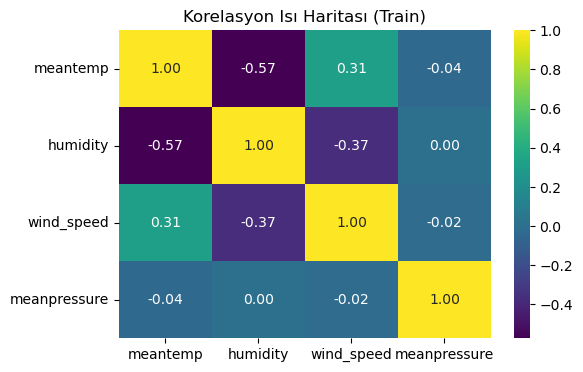

In [11]:
corr = train[NUM_COLS].corr()
print("\n=== Korelasyon Matrisi (train) ===")
display(corr)

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Korelasyon Isı Haritası (Train)")
plt.show()

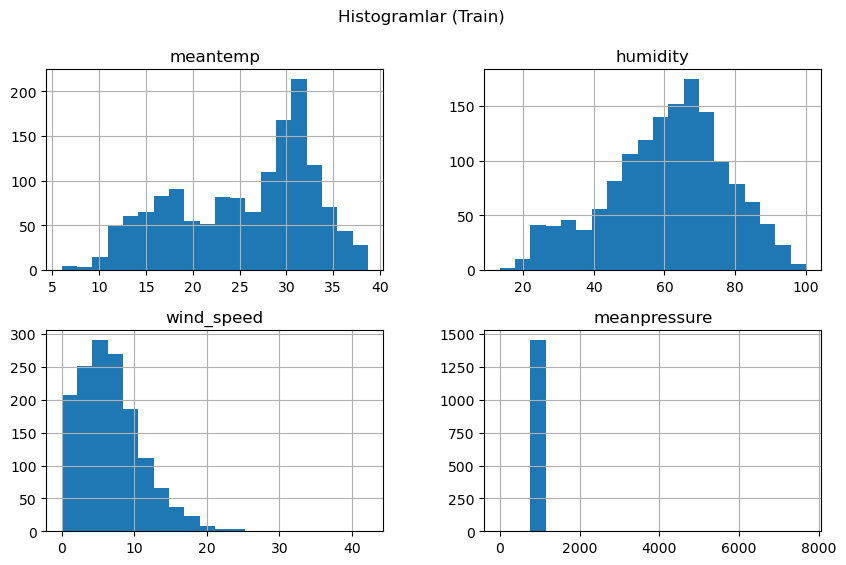

In [12]:
train[NUM_COLS].hist(figsize=(10,6), bins=20)
plt.suptitle("Histogramlar (Train)")
plt.show()

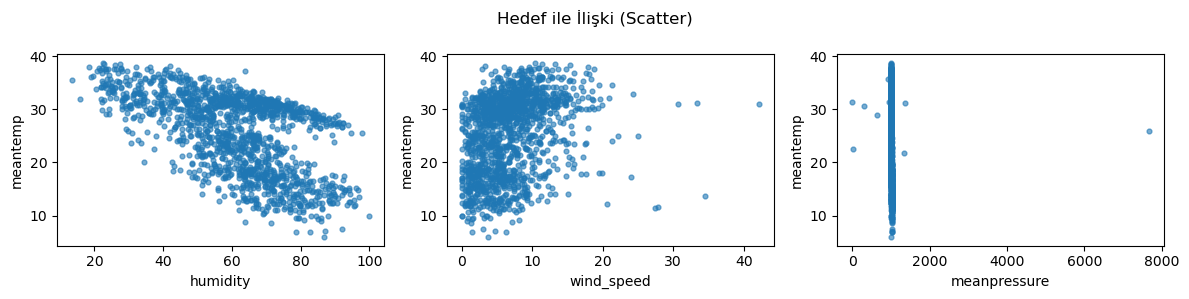

In [13]:
fig, axes = plt.subplots(1,3, figsize=(12,3))
for ax, col in enumerate(["humidity","wind_speed","meanpressure"]):
    axes[ax].scatter(train[col], train["meantemp"], s=12, alpha=0.6)
    axes[ax].set_xlabel(col); axes[ax].set_ylabel("meantemp")
fig.suptitle("Hedef ile İlişki (Scatter)")
plt.tight_layout(); plt.show()

In [14]:
def iqr_outlier_count(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return int(((s < lo) | (s > hi)).sum())

print("\n=== IQR Aykırı Değer Sayıları (train) ===")
for c in NUM_COLS:
    print(f"{c:12s}: {iqr_outlier_count(train[c])}")


=== IQR Aykırı Değer Sayıları (train) ===
meantemp    : 0
humidity    : 2
wind_speed  : 30
meanpressure: 9


# CRISP-DM 3 – Veri Hazırlama (Data Preparation):

In [15]:
# 2) SAYISALA GÜVENLİ DÖNÜŞÜM (binlik virgül, boşluk temizliği)
NUM_COLS = ["meantemp", "humidity", "wind_speed", "meanpressure"]

def to_numeric_clean(df, cols):
    for c in cols:
        if c in df.columns:
            # "1,015.667" -> "1015.667" -> float
            df[c] = (df[c].astype(str)
                            .str.replace(",", "", regex=False)
                            .str.replace(" ", "", regex=False))
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

train = to_numeric_clean(train, NUM_COLS)
test  = to_numeric_clean(test,  NUM_COLS)

In [16]:
# 3) EKSİK DEĞER İŞLEME (train ortalaması ile doldurma)
for c in NUM_COLS:
    if train[c].isna().any():
        train[c].fillna(train[c].mean(), inplace=True)
    if c != "meantemp" and c in test.columns:
        # test girdilerini train ortalamasıyla doldur (data leakage'ı önler)
        if test[c].isna().any():
            test[c].fillna(train[c].mean(), inplace=True)


In [17]:
# 4) MODEL GİRDİ/HEDEF AYRIŞTIRMA
FEATURES = ["humidity", "wind_speed", "meanpressure"]

X_train = train[FEATURES].copy()
y_train = train["meantemp"].copy()

# Testte hedef genelde yok; varsa bile model girdi setine dahil etmiyoruz
X_test = test[FEATURES].copy()

# CRISP-DM 4 – Modelleme (Modeling):

In [18]:
if "X_train" not in globals() or "y_train" not in globals() or "X_test" not in globals():
    # train_data / test_data kullanarak mini hazırlık
    FEATURES = ["humidity", "wind_speed", "meanpressure"]
    NUM_COLS = ["meantemp"] + FEATURES

    def to_numeric_clean(df, cols):
        df = df.copy()
        for c in cols:
            df[c] = (df[c].astype(str)
                              .str.replace(",", "", regex=False)
                              .str.replace(" ", "", regex=False))
            df[c] = pd.to_numeric(df[c], errors="coerce")
        return df

    train = to_numeric_clean(train_data.copy(), NUM_COLS)
    test  = to_numeric_clean(test_data.copy(),  NUM_COLS)

    for c in NUM_COLS:
        if train[c].isna().any():
            train[c].fillna(train[c].mean(), inplace=True)
        if c != "meantemp" and test[c].isna().any():
            test[c].fillna(train[c].mean(), inplace=True)

    X_train = train[FEATURES]
    y_train = train["meantemp"]
    X_test  = test[FEATURES]


In [19]:
FEATURES = list(X_train.columns)

pipe = Pipeline([
    ("scaler", MinMaxScaler()),     # KNIME Normalizer (Min-Max) ile aynı
    ("lr",     LinearRegression())
])

# Eğit
pipe.fit(X_train, y_train)

# --- Katsayıları raporla (ölçeklenmiş özellikler üzerinde) ---
coefs = pd.DataFrame({
    "feature": FEATURES,
    "coef": pipe.named_steps["lr"].coef_
}).sort_values("coef", ascending=False)

intercept = pipe.named_steps["lr"].intercept_

print("==== Lineer Regresyon (Min-Max ölçekli) ====")
print("Intercept:", round(intercept, 4))
print(coefs.to_string(index=False))



==== Lineer Regresyon (Min-Max ölçekli) ====
Intercept: 36.8361
     feature       coef
  wind_speed   7.263231
meanpressure -11.178097
    humidity -20.178867


In [20]:
# --- Train üzerinde tahmin (5. aşamada metriklere bakacağız) ---
y_pred_train = pipe.predict(X_train)

# --- Test tahminleri ---
y_pred_test = pipe.predict(X_test)
pred_test_df = pd.DataFrame({
    "Prediction_meantemp": y_pred_test
})

# Tarih kolonu varsa ekle (rapor kolaylığı)
if "date" in locals().get("test", pd.DataFrame()).columns:
    pred_test_df.insert(0, "date", test["date"].values)

# CRISP-DM 5 – Değerlendirme (Evaluation):

In [21]:

# 0) Model yoksa hızlıca kur ve eğit
if "pipe" not in globals():
    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("lr", LinearRegression())
    ])
    pipe.fit(X_train, y_train)

In [22]:
# 1) 5-fold çapraz doğrulama (train performansı)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error"
}
cv_res = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)

def pos(a): return -a  # sklearn negatif döndürür: pozitife çevir

cv_summary = {
    "CV_R2_mean": float(cv_res["test_r2"].mean()),
    "CV_R2_std":  float(cv_res["test_r2"].std()),
    "CV_MAE_mean": float(pos(cv_res["test_mae"]).mean()),
    "CV_MAE_std":  float(pos(cv_res["test_mae"]).std()),
    "CV_RMSE_mean": float(pos(cv_res["test_rmse"]).mean()),
    "CV_RMSE_std":  float(pos(cv_res["test_rmse"]).std()),
}
print("=== 5-Fold CV (Train) ===")
for k,v in cv_summary.items():
    print(f"{k}: {v:.4f}")

=== 5-Fold CV (Train) ===
CV_R2_mean: -0.1412
CV_R2_std: 0.9441
CV_MAE_mean: 5.1966
CV_MAE_std: 0.3268
CV_RMSE_mean: 7.3780
CV_RMSE_std: 2.8502


In [23]:
# 2) In-sample (train üzerinde) metrikler
y_pred_tr = pipe.predict(X_train)
train_r2   = r2_score(y_train, y_pred_tr)
train_mae  = mean_absolute_error(y_train, y_pred_tr)
train_rmse = mean_squared_error(y_train, y_pred_tr, squared=False)

print("\n=== In-sample (Train) ===")
print(f"R2   : {train_r2:.4f}")
print(f"MAE  : {train_mae:.4f}")
print(f"RMSE : {train_rmse:.4f}")


=== In-sample (Train) ===
R2   : 0.3384
MAE  : 5.0697
RMSE : 5.9750


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
# 3) Test tahmini ve (varsa) test metrikleri
test_metrics = {}
if "X_test" in globals():
    y_pred_test = pipe.predict(X_test)
    if "test" in globals() and "meantemp" in test.columns and test["meantemp"].notna().any():
        y_true = pd.to_numeric(test["meantemp"], errors="coerce")
        m = y_true.notna()
        if m.sum() > 0:
            test_r2   = r2_score(y_true[m], y_pred_test[m])
            test_mae  = mean_absolute_error(y_true[m], y_pred_test[m])
            test_rmse = mean_squared_error(y_true[m], y_pred_test[m], squared=False)
            test_metrics = {"Test_R2":float(test_r2), "Test_MAE":float(test_mae), "Test_RMSE":float(test_rmse)}
            print("\n=== Test (meantemp mevcutsa) ===")
            print(f"R2   : {test_r2:.4f}")
            print(f"MAE  : {test_mae:.4f}")
            print(f"RMSE : {test_rmse:.4f}")



=== Test (meantemp mevcutsa) ===
R2   : 0.0562
MAE  : 5.2745
RMSE : 6.1514


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


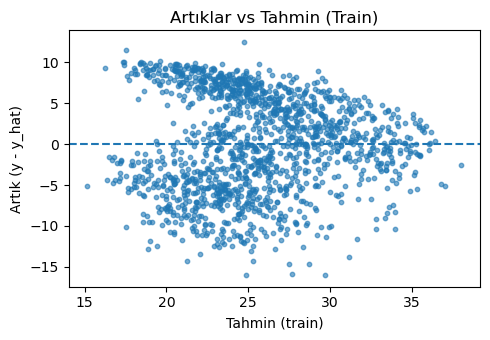

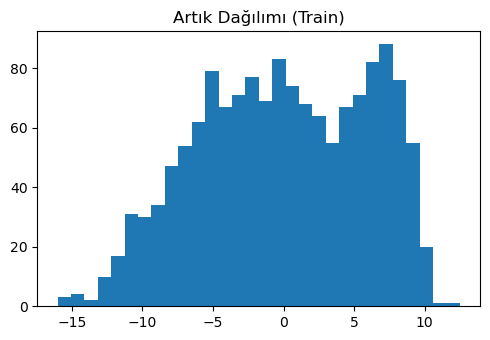

In [25]:
# 4) Artık (residual) analizi grafikleri (train)
residuals = y_train - y_pred_tr

plt.figure(figsize=(5,3.5))
plt.scatter(y_pred_tr, residuals, s=10, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Tahmin (train)"); plt.ylabel("Artık (y - y_hat)")
plt.title("Artıklar vs Tahmin (Train)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3.5))
plt.hist(residuals, bins=30)
plt.title("Artık Dağılımı (Train)")
plt.tight_layout()
plt.show()


In [ ]:
# MULTI-MODEL BENCHMARK + "Hafif AutoML"
# =========================
import numpy as np, pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error

# Modeller
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [27]:
# =========================



def to_numeric_clean(df, cols):
    df = df.copy()
    for c in cols:
        df[c] = (df[c].astype(str).str.replace(",", "", regex=False).str.replace(" ", "", regex=False))
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

train = train_data.copy()
test  = test_data.copy()
for d in (train,test):
    d["date"] = pd.to_datetime(d["date"], errors="coerce")

NUM = ["meantemp","humidity","wind_speed","meanpressure"]
train = to_numeric_clean(train, NUM)
test  = to_numeric_clean(test,  NUM)

for c in NUM:
    train[c].fillna(train[c].mean(), inplace=True)
    if c!="meantemp":
        test[c].fillna(train[c].mean(), inplace=True)

FEATURES = ["humidity","wind_speed","meanpressure"]
X_train, y_train = train[FEATURES], train["meantemp"]
X_test = test[FEATURES]

# 1) Ortak ön-işleme: (a) MinMax, (b) Standard (farklı modellere uygun)
minmax = ColumnTransformer([("mm", MinMaxScaler(), FEATURES)], remainder="drop")
stand  = ColumnTransformer([("ss", StandardScaler(), FEATURES)], remainder="drop")

# 2) Aday modeller + uygun ön-işleme
candidates = {
    # Lineer ailesi
    "LinearRegression":      Pipeline([("prep", minmax), ("mdl", LinearRegression())]),
    "RidgeCV":               Pipeline([("prep", stand),  ("mdl", RidgeCV(alphas=np.logspace(-3,3,25)))]),
    "LassoCV":               Pipeline([("prep", stand),  ("mdl", LassoCV(alphas=np.logspace(-3,2,20), max_iter=5000, cv=5))]),
    "ElasticNetCV":          Pipeline([("prep", stand),  ("mdl", ElasticNetCV(l1_ratio=[.2,.5,.8], alphas=np.logspace(-3,2,15), max_iter=5000, cv=5))]),
    # Non-lineer
    "KNN":                   Pipeline([("prep", minmax), ("mdl", KNeighborsRegressor(n_neighbors=7))]),
    "SVR_RBF":               Pipeline([("prep", stand),  ("mdl", SVR(kernel="rbf", C=10.0, epsilon=0.2))]),
    "DecisionTree":          Pipeline([("prep", minmax), ("mdl", DecisionTreeRegressor(max_depth=6, random_state=42))]),
    "RandomForest":          Pipeline([("prep", minmax), ("mdl", RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42))]),
    "GradientBoosting":      Pipeline([("prep", minmax), ("mdl", GradientBoostingRegressor(random_state=42))]),
}

# 3) Zaman serisi çapraz doğrulama (train kronolojisini korur)
tscv = TimeSeriesSplit(n_splits=5)

scoring = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error"
}

def pos(x): return -x

rows = []
for name, pipe in candidates.items():
    cv = cross_validate(pipe, X_train, y_train, cv=tscv, scoring=scoring, n_jobs=-1)
    row = {
        "model": name,
        "CV_R2_mean":  cv["test_r2"].mean(),
        "CV_R2_std":   cv["test_r2"].std(),
        "CV_MAE_mean": pos(cv["test_mae"]).mean(),
        "CV_RMSE_mean":pos(cv["test_rmse"]).mean()
    }
    rows.append(row)

compare = pd.DataFrame(rows).sort_values(["CV_RMSE_mean","CV_R2_mean"], ascending=[True,False])
print(compare)
compare.to_csv("model_compare.csv", index=False)
best_name = compare.iloc[0]["model"]
print(f"\nEn iyi CV (TimeSeriesSplit) model: {best_name}")

# 4) Basit hiperparametre taraması (en iyi 2 model için küçük grid)
grids = {
    "RandomForest": {
        "prep": [minmax],
        "mdl__n_estimators": [300,500,800],
        "mdl__max_depth": [None,8,12],
        "mdl__min_samples_leaf": [1,2,5]
    },
    "GradientBoosting": {
        "prep": [minmax],
        "mdl__n_estimators": [200,300,500],
        "mdl__learning_rate": [0.05,0.1,0.2],
        "mdl__max_depth": [2,3,4]
    },
    "SVR_RBF": {
        "prep": [stand],
        "mdl__C": [1,3,10,30],
        "mdl__epsilon": [0.1,0.2,0.5],
        "mdl__gamma": ["scale","auto"]
    }
}

tuned_models = {}
for name in [best_name, "RandomForest", "GradientBoosting", "SVR_RBF"]:
    if name not in candidates or name not in grids: 
        continue
    print(f"\nGridSearch: {name}")
    gs = GridSearchCV(candidates[name], param_grid=grids[name], cv=tscv,
                      scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)
    tuned_models[name] = gs.best_estimator_
    print("Best params:", gs.best_params_, " | CV best RMSE:", -gs.best_score_)

# 5) En iyi modeli seç ve testte tahmin üret
final_model = tuned_models.get(best_name, candidates[best_name])
final_model.fit(X_train, y_train)
y_pred_tr = final_model.predict(X_train)
y_pred_te = final_model.predict(X_test)

# Train metrikleri
R2_tr   = r2_score(y_train, y_pred_tr)
MAE_tr  = mean_absolute_error(y_train, y_pred_tr)
RMSE_tr = mean_squared_error(y_train, y_pred_tr, squared=False)
print(f"\nTrain: R2={R2_tr:.3f} | MAE={MAE_tr:.3f} | RMSE={RMSE_tr:.3f}")




C:\Users\pc\AppData\Local\Temp\ipykernel_53024\1252210140.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[c].fillna(train[c].mean(), inplace=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_53024\1252210140.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

              model  CV_R2_mean   CV_R2_std  CV_MAE_mean  CV_RMSE_mean
8  GradientBoosting    0.808181    0.065822     2.182688      2.847030
7      RandomForest    0.793765    0.073200     2.244381      2.945549
6      DecisionTree    0.751195    0.081971     2.421954      3.253519
5           SVR_RBF    0.571811    0.538436     2.479929      3.603836
4               KNN    0.547652    0.515051     3.108304      3.807349
3      ElasticNetCV -462.419001  925.923953     7.291245     68.283805
2           LassoCV -465.011518  931.099915     7.304165     68.476679
1           RidgeCV -470.011993  941.125667     7.315436     68.799825
0  LinearRegression -471.029347  943.134798     7.316891     68.896891

En iyi CV (TimeSeriesSplit) model: GradientBoosting

GridSearch: GradientBoosting
Best params: {'mdl__learning_rate': 0.05, 'mdl__max_depth': 3, 'mdl__n_estimators': 200, 'prep': ColumnTransformer(transformers=[('mm', MinMaxScaler(),
                                 ['humidity', 'wind_spe

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
